<a href="https://colab.research.google.com/github/oikn2018/CS6910_assignment_3/blob/main/a3_wo_attn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Commands
! pip install wget
! pip install gdown
! pip install --upgrade gdown
# ! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=0b8004d1f667b7577503de1cce405ede4e71025f2a6f5c96d7457a45dcf46e7b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torch.optim as optim
from torch.autograd import Variable
import os
import gdown
# import wandb
from io import open
import string, time, math
import wget
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset
import re

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
# CUDA
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic=True
# torch.backends.cudnn.benchmark=False

In [4]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Getting the Dataset
url = 'https://drive.google.com/uc?id=1uRKU4as2NlS9i8sdLRS1e326vQRdhvfw&export=download'
# filename = os.path.basename(url)
# print(filename)

if not os.path.exists("aksharantar_sampled"):
  filename = gdown.download(url = url, quiet=False, fuzzy=True)
  print(filename)
  with ZipFile(filename, 'r') as z:
    print('Extracting files...')
    z.extractall()
    print('Done!')
  os.remove(filename)

Downloading...
From: https://drive.google.com/uc?id=1uRKU4as2NlS9i8sdLRS1e326vQRdhvfw
To: /content/aksharantar_sampled.zip
100%|██████████| 14.0M/14.0M [00:00<00:00, 40.9MB/s]


aksharantar_sampled.zip
Extracting files...
Done!


In [6]:
eng_alpha = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '<PAD>'

eng_alpha2idx = {pad_char: 0}
for index, alpha in enumerate(eng_alpha):
  eng_alpha2idx[alpha] = index+1

print(eng_alpha2idx)

{'<PAD>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [7]:
# Change Indic Language here
# indic_lang = 'ben'
indic_lang = 'hin'

In [8]:
# Bengali Unicode Hex Range: 2432-2558
# Hindi Unicode Hex Range: 2304-2431

min_range = 2304
max_range = 2431

if indic_lang == 'ben':
  min_range = 2432
  max_range = 2558
elif indic_lang == 'hindi':
  min_range = 2304
  max_range = 2431

indic_alpha = [chr(alpha) for alpha in range(min_range, max_range + 1)]
print(indic_alpha)
indic_alpha_size = len(indic_alpha)

indic_alpha2idx = {pad_char: 0}
for index, alpha in enumerate(indic_alpha):
  indic_alpha2idx[alpha] = index+1

print(indic_alpha2idx)

['ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']
{'<PAD>': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध':

In [9]:
indic_langs = sorted([indic_lang for indic_lang in os.listdir("aksharantar_sampled") if indic_lang != '.DS_Store'])
print(indic_langs)

['asm', 'ben', 'brx', 'guj', 'hin', 'kan', 'kas', 'kok', 'mai', 'mal', 'mar', 'mni', 'ori', 'pan', 'san', 'sid', 'tam', 'tel', 'urd']


In [ ]:
# X_train = []
# y_train = []
# data_train = []

# X_val = []
# y_val = []
# data_val = []

# X_test = []
# y_test = []
# data_test = []

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_train.csv', 'r') as f_train:
#   for line in f_train:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_train.append(eng_word)
#     y_train.append(indic_word)
#     data_train.append((eng_word, indic_word))

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_valid.csv', 'r') as f_val:
#   for line in f_val:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_val.append(eng_word)
#     y_val.append(indic_word)
#     data_val.append((eng_word, indic_word))

# with open(f'aksharantar_sampled/{indic_lang}/{indic_lang}_test.csv', 'r') as f_test:
#   for line in f_test:
#     line = line.split(',')
#     eng_word = line[0].strip()
#     indic_word = line[1].strip()
#     X_test.append(eng_word)
#     y_test.append(indic_word)
#     data_test.append((eng_word, indic_word))

In [ ]:
# print(len(X_train), len(X_val), len(X_test))

In [ ]:
# print(X_train[0].upper(), eng_rep(X_train[0].upper(), eng_alpha2idx))

# non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# # Remove all English non-letters
# def cleanEnglishVocab(line):
#   line = line.upper

# def cleanHindiVocab(line):
#   pass

In [10]:
class TransLit_DataLoader(Dataset):
  def __init__(self, filename):
    self.eng_lang_words, self.indic_lang_words = self.readDataset(filename)
    self.shuffle_indices = list(range(len(self.eng_lang_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0

  def __len__(self):
    return len(self.eng_lang_words)

  def __getitem__(self, idx):
    return self.eng_lang_words[idx], self.indic_lang_words[idx]

  def readDataset(self, filename):
    X = []
    y = []
    # data = []

    with open(filename, 'r') as f:
      for line in f:
        line = line.split(',')
        eng_word = line[0].strip()
        indic_word = line[1].strip()
        X.append(eng_word)
        y.append(indic_word)
        # data_train.append((eng_word, indic_word))
    return X, y

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.eng_lang_words)))

  def get_batch_from_array(self, batch_size, array):
    end = self.shuffle_start_index + batch_size
    batch = []
    if end >= len(self.eng_lang_words):
      batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_lang_words)]]
    return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]

  def get_batch(self, batch_size, postprocess = True):
    eng_lang_batch = self.get_batch_from_array(batch_size, self.eng_lang_words)
    indic_lang_batch = self.get_batch_from_array(batch_size, self.indic_lang_words)
    self.shuffle_start_index += batch_size + 1

    # Reshuffle if 1 epoch is complete
    if self.shuffle_start_index >= len(self.eng_lang_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_index = 0

    return eng_lang_batch, indic_lang_batch


In [11]:
data_train = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_train.csv')
data_val = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_valid.csv')
data_test = TransLit_DataLoader(f'aksharantar_sampled/{indic_lang}/{indic_lang}_test.csv')

In [ ]:
# data_train.get_random_sample()

In [ ]:
# data_train.get_batch(8)

In [12]:
# Basic Data Visualization
print('Train Set Size: ', len(data_train))
print('Validation Set Size: ', len(data_val))
print('Test Set Size: ', len(data_test))
eng, indic = data_train.get_random_sample()
print(f'Sample data from Train Set: \n{eng} - {indic}')

Train Set Size:  51200
Validation Set Size:  4096
Test Set Size:  4096
Sample data from Train Set: 
agricultule - एग्रीकल्चल


In [13]:
# Encoding words

def eng_rep(eng_word, letter2idx, device = 'cpu'):
  eng_word = eng_word.upper()
  rep = torch.zeros(len(eng_word) + 1, 1, len(letter2idx)).to(device)
  for letter_idx, letter in enumerate(eng_word):
    pos = letter2idx[letter]
    rep[letter_idx][0][pos] = 1
  pad_pos = letter2idx[pad_char]
  rep[letter_idx+1][0][pad_pos] = 1
  return rep

def gt_rep(indic_word, letter2idx, device = 'cpu'):
  gt_rep = torch.zeros([len(indic_word) + 1, 1], dtype = torch.long).to(device)
  for letter_idx, letter in enumerate(indic_word):
    pos = letter2idx[letter]
    gt_rep[letter_idx][0] = pos
  gt_rep[letter_idx+1][0] = letter2idx[pad_char]
  return gt_rep

In [14]:
# Visualization of Encoded Words for English and Indic Language
eng_word, indic_word = data_train.get_random_sample()
eng_word_rep = eng_rep(eng_word, eng_alpha2idx)
indic_word_rep = gt_rep(indic_word, indic_alpha2idx)
print(eng_word, eng_word_rep)
print(indic_word, indic_word_rep)
print(eng_word_rep.shape, indic_word_rep.shape)

mhilaaon tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 

In [15]:
def infer(net, word,max_output_chars, device='cpu'):
    net.eval().to(device)
    word_ohe = eng_rep(word, eng_alpha2idx)
    output = net(word_ohe, max_output_chars)
    return output

In [147]:
MAX_OUTPUT_CHARS = 30

class GRU_EncDec(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(GRU_EncDec, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # Encoder
    out, hidden = self.encoder_rnn_cell(input)

    if self.verbose:
      print('Encoder input', input.shape)
      print('Encoder output', out.shape)
      print('Encoder hidden', hidden.shape)

    # Decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1,1,self.output_size).to(device)
    outputs = []

    if self.verbose:
      print('Decoder state', decoder_state.shape)
      print('Decoder input', decoder_input.shape)

    for i in range(max_output_chars):
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

      if self.verbose:
        print('Decoder intermediate output', out.shape)

      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))

      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False

      max_idx = torch.argmax(out,2,keepdim = True)

      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1,1,1)
      
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)

      decoder_input = one_hot.detach()
    return outputs
    

In [135]:
# MAX_OUTPUT_CHARS = 30

# class GRU_EncDec(nn.Module):

#   def __init__(self, input_size, hidden_size, output_size, attn=False, verbose=False):
#     super(GRU_EncDec, self).__init__()

#     self.hidden_size = hidden_size
#     self.output_size = output_size
#     self.attn = attn

#     self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
#     if self.attn:
#       self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
#     else:
#       self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)

#     self.h2o = nn.Linear(hidden_size, output_size)
#     self.softmax = nn.LogSoftmax(dim=2)

#     if self.attn:
#       self.U = nn.Linear(self.hidden_size, self.hidden_size)
#       self.W = nn.Linear(self.hidden_size, self.hidden_size)
#       self.attn_layer = nn.Linear(self.hidden_size, 1)
#       self.out2hidden = nn.Linear(self.output_size, self.hidden_size)

#     self.verbose = verbose

#   def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

#     # Encoder
#     if self.attn:
#       encoder_outputs, hidden = self.encoder_rnn_cell(input)
#       encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
#     else:
#       out, hidden = self.encoder_rnn_cell(input)

#     if self.verbose:
#       print('Encoder input', input.shape)
#       if self.attn:
#         print('Encoder output', encoder_outputs.shape)
#       else:
#         print('Encoder output', out.shape)
#       print('Encoder hidden', hidden.shape)

#     # Decoder
#     decoder_state = hidden
#     decoder_input = torch.zeros(1,1,self.output_size).to(device)
#     outputs = []

#     if self.attn:
#       U = self.U(encoder_outputs)

#     if self.verbose:
#       print('Decoder state', decoder_state.shape)
#       if self.attn:
#         print('Decoder intermediate input', decoder_input.shape)
#         print('U*Encoder output', U.shape)
#       else:
#         print('Decoder input', decoder_input.shape)

#     for i in range(max_output_chars):
#       if self.attn:
#         W = self.W(decoder_state.view(1,-1).repeat(encoder_outputs.shape[0],1))
#         V = self.attn_layer(torch.tanh(U+W))

#         attn_weights = F.softmax(V.view(1,-1), dim=1)

#         if self.verbose:
#           print('W*Decoder state', W.shape)
#           print('V', V.shape)
#           print('Attn_Layer', attn_weights.shape)

#         attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

#         embedding = self.out2hidden(decoder_input)
#         decoder_input = torch.cat((embedding[0], attn_applied[0]), 1)

#         if self.verbose:
#           print('Attn LC', attn_applied.shape)
#           print('Decoder input', decoder_input.shape)

#       out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

#       if self.verbose:
#         print('Decoder intermediate output', out.shape)

#       out = self.h2o(decoder_state)
#       out = self.softmax(out)
#       outputs.append(out.view(1,-1))

#       if self.verbose:
#         print('Decoder output', out.shape)
#         self.verbose = False

#       max_idx = torch.argmax(out,2,keepdim = True)

#       if not ground_truth is None:
#         max_idx = ground_truth[i].reshape(1,1,1)
      
#       one_hot = torch.FloatTensor(out.shape).to(device)
#       # one_hot.zero_() ?
#       one_hot.scatter_(2,max_idx,1)

#       decoder_input = one_hot.detach()
#     return outputs

In [136]:
# net = GRU_EncDec(len(eng_alpha2idx), 1024, len(indic_alpha2idx), verbose=True)

In [137]:
# out = infer(net, 'india', 30)

Encoder input torch.Size([6, 1, 27])
Encoder output torch.Size([6, 1, 1024])
Encoder hidden torch.Size([1, 1, 1024])
Decoder state torch.Size([1, 1, 1024])
Decoder input torch.Size([1, 1, 129])
Decoder intermediate output torch.Size([1, 1, 1024])
Decoder output torch.Size([1, 1, 129])


In [148]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = data_train.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = eng_rep(eng_batch[i], eng_alpha2idx, device)
        gt = gt_rep(hindi_batch[i], indic_alpha2idx, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [149]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    # (loss_val, batch_ret) =  )
    # eng_batch, indic_batch = data_val.get_batch(batch_size)
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto) )/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i], 'Validation Accuracy: ', calc_word_accuracy(net, data=data_val))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
            torch.save(net.state_dict(), f'{indic_lang}_model.pth')
    return loss_arr

In [150]:
net = GRU_EncDec(len(eng_alpha2idx), 512, len(indic_alpha2idx))

0
Iteration 299 Loss 0.4087764322757721 Validation Accuracy:  0.0


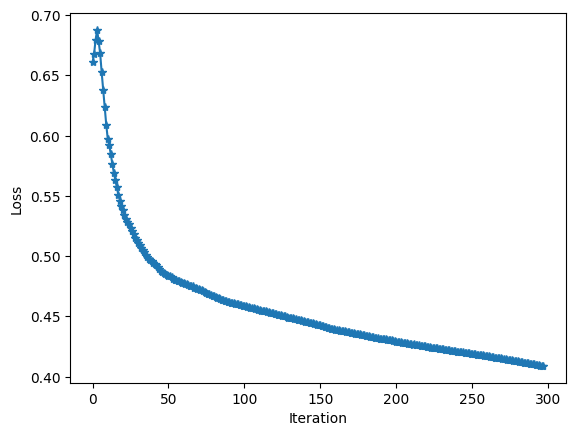

In [ ]:
%%time
train_setup(net, lr=0.001, n_batches=1500, batch_size = 64, display_freq=100, device = device_gpu)

In [58]:
def calc_accuracy(net, device = 'cpu', data = data_val):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    count = 0
    for i in range(len(data)):
        eng_word, indic_word = data[i]
        gt = gt_rep(indic_word, indic_alpha2idx, device)
        outputs = infer(net, eng_word, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            
            indic_pos = indices.tolist()[0]
            if indic_pos[0] == gt[index][0]:
              correct += 1
            
        accuracy += correct/gt.shape[0]
    accuracy /= len(data)
        
    #     char_level_acc = correct/(gt.shape[0]-1)
    #     indic_word_pred = get_indic_pred_word(net, eng_word)
        
    #     # print(correct, gt.shape[0]-1)
    #     # break
    #     # print(char_level_acc)
        
    #     if char_level_acc == 1.0:
    #       count += 1
    #       print(count)
    #       print(f'{eng_word}-{indic_word}-{indic_word_pred}')
    #       # accuracy += char_level_acc
    # print(len(data))
    # accuracy = count/len(data)
    
    return accuracy

In [62]:
new_net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx), verbose=False)
new_net.load_state_dict(torch.load(f'{indic_lang}_model.pth'))

<All keys matched successfully>

In [70]:
def get_indic_pred_word(net, eng_word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, eng_word, 30, device)
    # print(outputs)
    indic_output = ''
    for index, out in enumerate(outputs):
      # print(index)
      val, indices = out.topk(1)
      # print(val)
      index = indices.tolist()[0][0]
      # print(index)
      if index == 0:
          break
      indic_char = indic_alpha[index+1]
      # print(indic_char)
      indic_output += indic_char
    # print(eng_word + ' - ' + indic_output)
    return indic_output

In [107]:
indic_alpha.index('ॿ')

127

In [143]:
def calc_word_accuracy(net, device = 'cpu', data = data_val):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    count = 0
    for i in range(len(data)):
        eng_word, indic_word = data[i]
        gt = gt_rep(indic_word, indic_alpha2idx, device)

        outputs = infer(net, eng_word, gt.shape[0], device)
        correct = 0
        indic_output = ''


        for index, out in enumerate(outputs):
                val, indices = out.topk(1)
                
                indic_pos = indices.tolist()[0]
                # print(indic_pos)
                
                if indic_pos[0] == gt[index][0]:
                  correct += 1
                  if indic_pos[0] != 0:
                    indic_output += indic_alpha[indic_pos[0]-1]

        
        char_level_acc = correct/gt.shape[0]

        # if index ==2:
        #   break
        
        if char_level_acc == 1.0:
          count += 1
          # print(f'{eng_word}-{indic_word}-{indic_output}')
    print(count)
    accuracy = count/len(data)
    
    return accuracy

In [134]:
accuracy_val = calc_word_accuracy(new_net, data=data_test) * 100
# print(indic_alpha2idx)
print('Validation Accuracy w/o attention ', accuracy_val)


263
Validation Accuracy w/o attention  6.4208984375


In [ ]:
%%time
# new_net = GRU_EncDec(len(eng_alpha2idx), 256, len(indic_alpha2idx), verbose=True)
# new_net.load_state_dict(torch.load("model.pth"))
accuracy_train = calc_accuracy(new_net, data=data_train) * 100
print('Train Accuracy w/o attention ', accuracy_train)
accuracy_test = calc_accuracy(new_net, data=data_test) * 100

# accuracy_attn = calc_accuracy(net_att) * 100
print('Test Accuracy w/o attention ', accuracy_test)
# print('Acurracy with attention', accuracy_attn)

KeyboardInterrupt: ignored

In [ ]:
MAX_OUTPUT_CHARS = 30

class GRU_EncDec(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, attn=False, verbose=False):
    super(GRU_EncDec, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size
    self.attn = attn

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    if self.attn:
      self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
    else:
      self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

    if self.attn:
      self.U = nn.Linear(self.hidden_size, self.hidden_size)
      self.W = nn.Linear(self.hidden_size, self.hidden_size)
      self.attn_layer = nn.Linear(self.hidden_size, 1)
      self.out2hidden = nn.Linear(self.output_size, self.hidden_size)

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # Encoder
    if self.attn:
      encoder_outputs, hidden = self.encoder_rnn_cell(input)
      encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
    else:
      out, hidden = self.encoder_rnn_cell(input)

    if self.verbose:
      print('Encoder input', input.shape)
      if self.attn:
        print('Encoder output', encoder_outputs.shape)
      else:
        print('Encoder output', out.shape)
      print('Encoder hidden', hidden.shape)

    # Decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1,1,self.output_size).to(device)
    outputs = []

    if self.attn:
      U = self.U(encoder_outputs)

    if self.verbose:
      print('Decoder state', decoder_state.shape)
      if self.attn:
        print('Decoder intermediate input', decoder_input.shape)
        print('U*Encoder output', U.shape)
      else:
        print('Decoder input', decoder_input.shape)

    for i in range(max_output_chars):
      if self.attn:
        W = self.W(decoder_state.view(1,-1).repeat(encoder_outputs.shape[0],1))
        V = self.attn_layer(torch.tanh(U+W))
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

      if self.verbose:
        print('Decoder intermediate output', out.shape)

      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))

      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False

      max_idx = torch.argmax(out,2,keepdim = True)

      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1,1,1)
      
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)

      decoder_input = one_hot.detach()
    return outputs